**DSCI 100: Project Final Report**
===
---

Introduction:
---

A research group led by Frank Wood has set up a Minecraft server to examine how people play video games. The data collected involves player characteristics and play times. Here, we ask a predictive question based on this data, to explore potential trends and relationships between players with similar traits.

Specifically, we ask *"<u>Can player age and hours played predict whether a player will subscribe to the video game newsletter in players.csv?</u>"*

To do this, we use the `players.csv` dataset, which contains seven variables and 196 observations. These variables include
* `experience (chr)`: Player's level of in-game experience.
* `subscribe (lgl)`: Whether player is subscribed to the newsletter or not.    
* `hashedEmail (chr)`: Player's hashed email.  
* `played_hours (dbl)`: Player's number of hours played.  
* `name (chr)`: Player's name.  
* `gender (chr)`: Player's gender.  
* `Age (dbl)`: Player's age.

Methods & Results:
---

The data was read as a `.csv` file using a URL from a GitHub repository. To prepare the data for answering the predictive question, the predictors and response variables, `Age`, `played_hours`, and `subscribe`, were selected and the response variable was set to a factor `(fct)` type to be used in a classification setting. Summary statistics were calculated, such as the mean, median, etc. of the two predictor variables.

The specific question was answered with K-NN classification, as the response variable is not numeric but rather composed of two distinct values, `TRUE` and `FALSE`, meaning it is categorical.

The data was split into 75% training data and 25% testing data so that it could be trained on a large portion of data and still evaluated on a considerable portion of the data. Also, the use of 5-fold cross-validation with a set randomisation seed gave the model more robust data to operate on. To improve the model, a value of K was selected that maximised the model's accuracy. This K value came from the range 1 to 10, to allow for a reasonable array of options, while not greatly slowing the time it takes the model to tun. The predictors were scaled and centred on avoiding issues with one predictor unintentionally outweighing the other in the process of nearest neighbours scaling.

With this value K and a multi-fold framework, the K-NN classification was performed. Then, the quality of the model was assessed by its metrics on the test data and the effectiveness of the model was visualised with plots of accuracy.

The variables `Age` and `played_hours` were selected due to their numeric type and because it seems interesting to explore whether there is a relation between these characteristics of a player and whether or not they will subscribe to a game-related newsletter. This addresses interesting questions, such as whether different ages tend to subscribe to newsletters relating to games they like or how much a person might play before becoming involved enough in a gaming community to subscribe to a game-related newsletter.

---

**Loading in the library for wrangling and classification and reading in the players.csv dataset.**

In [138]:
library(tidyverse)
players_url <- "https://raw.githubusercontent.com/Rafee1012/dsci-100-group-project-10/refs/heads/main/players%20(3).csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


---

Wrangling data into a necessary format for answering the predictive question.

In [139]:
players <- players |>
    select(Age, played_hours, subscribe) |>
    mutate(subscribe = as_factor(subscribe))

head(players)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
21,0.7,TRUE
21,0.1,TRUE
17,0.0,TRUE


---

**Summarising data relevant for planned analysis.**

Predictor Variables:
- `Age (dbl)`
- `played_hours (dbl)`

These predictors were chosen to explore if they share any meaningful relationship in predicting subscription status, as it seems interesting to see whether players of different ages and time spent playing are more likely to become involved in the community surrounding a game they enjoy and subscribe to a game-related newsletter.

Response Variable: `subscribe (fct)`

Note: This code shows that people with no playtime can still be subscribed, meaning those players cannot be filtered out or disregarded from the planned analysis.

In [235]:
players |>
    filter(played_hours == 0, subscribe == TRUE) |>
    nrow()

[1] 58

***TABLE 1: Summary Statistics for Response Variable *subscribe****

In [236]:
total <- players |>
    mutate(total = n()) |>
    slice_head(n = 1) |>
    pull()

options <- players |>
    group_by(subscribe) |>
    summarize(count = n(),
              "distribution (%)" = n() / total * 100)

options

subscribe,count,distribution (%)
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


***TABLE 2: Summary Statistics for Predictor *Age****

In [237]:
summary_Age <- players |>
    mutate(mean_age = mean(Age, na.rm = TRUE), mode_age = mode(Age), med_age = median(Age, na.rm = TRUE),
           sd_age = sd(Age, na.rm = TRUE), min_age = min(Age, na.rm = TRUE), max_age = max(Age, na.rm = TRUE)) |>
    select(-played_hours, -subscribe, -Age) |>
    slice_head(n = 1)

summary_Age

mean_age,mode_age,med_age,sd_age,min_age,max_age
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
20.52062,numeric,19,6.174667,8,50


***TABLE 3: Summary Statistics for Predictor *played_hours****

In [238]:
summary_played_hours <- players |>
    mutate(mean_played_hours = mean(played_hours, na.rm = TRUE), mode_played_hours = mode(played_hours),
           med_played_hours = median(played_hours, na.rm = TRUE), sd_played_hours = sd(played_hours, na.rm = TRUE),
           min_played_hours = min(played_hours, na.rm = TRUE), max_played_hours = max(played_hours, na.rm = TRUE)) |>
    select(-played_hours, -subscribe, -Age) |>
    slice_head(n = 1)

summary_played_hours

mean_played_hours,mode_played_hours,med_played_hours,sd_played_hours,min_played_hours,max_played_hours
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
5.904639,numeric,0.1,28.49793,0,223.1


---

**Visualising data relevant for planned analysis.**

***FIGURE 1: Plot of Player Age vs. Player In-Game Playtime, Coloured by Player Subscription Status***

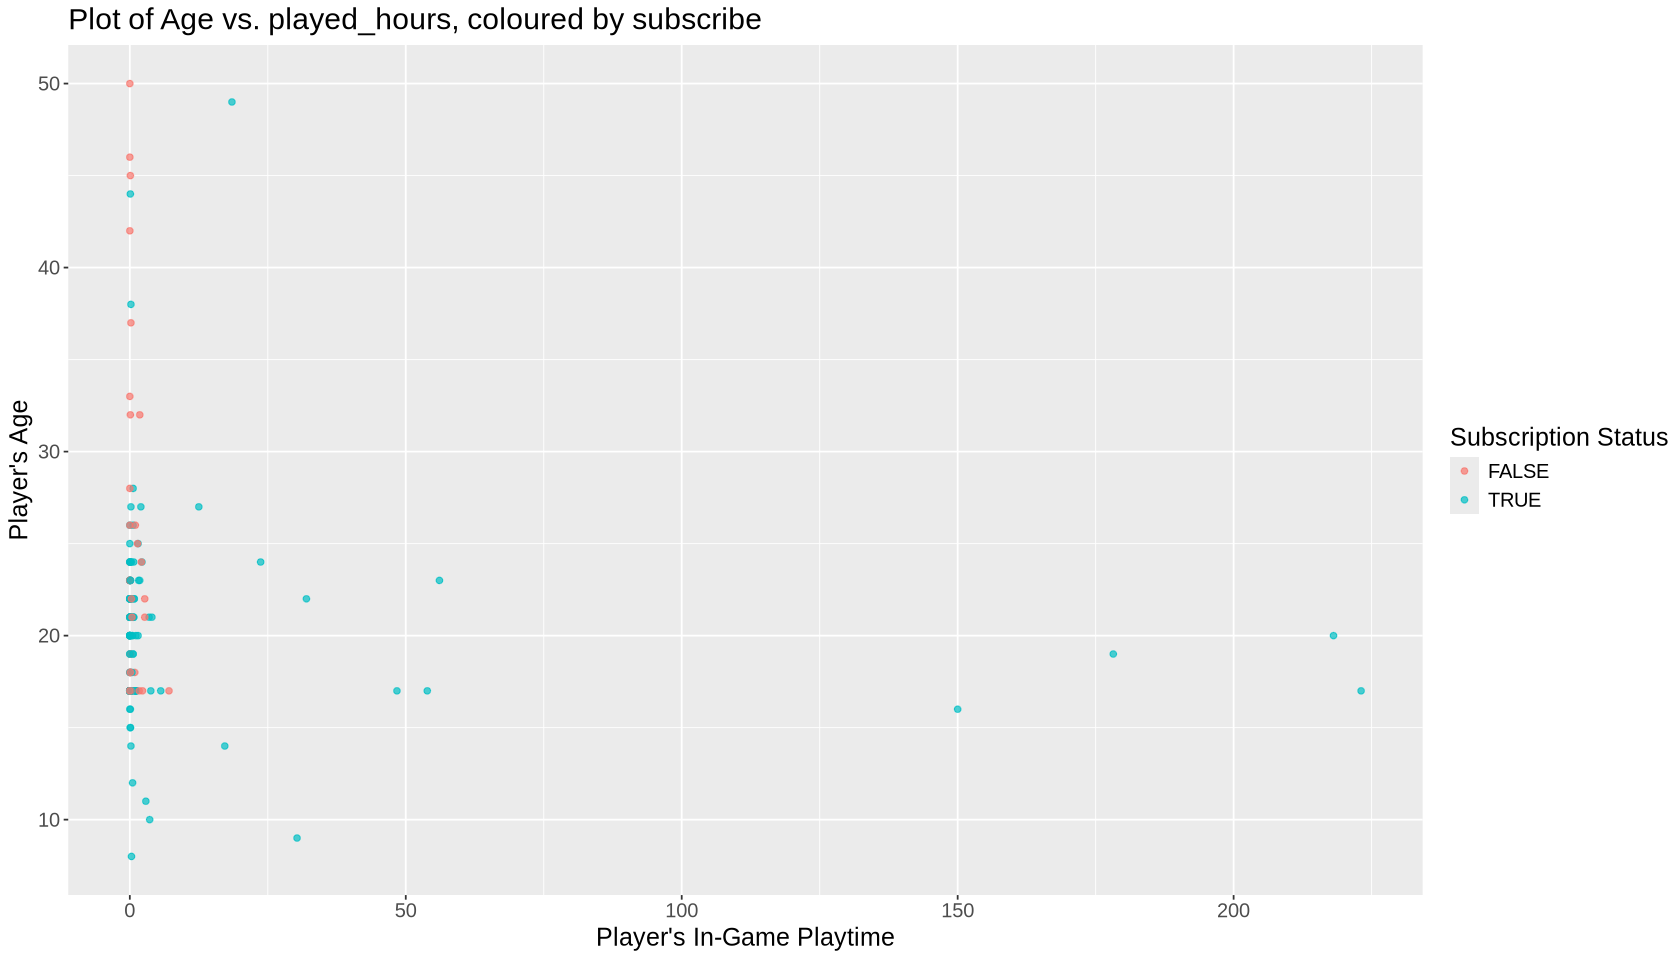

In [239]:
options(repr.plot.height = 8, repr.plot.width = 14)

prediction_plot <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
        geom_point(alpha = 0.7) +
        labs(x = "Player's In-Game Playtime", y = "Player's Age", color = "Subscription Status") +
        ggtitle("Plot of Age vs. played_hours, coloured by subscribe") +
        theme(text = element_text(size = 15))

prediction_plot

---

**Performing K-NN classification to answer the predictive question.**

- Adding necessary libraries for wrangling and predicting
- Setting seed to control randomisation
- Reading in data as `.csv` file
- Converting data to format suitable for K-NN classification

In [558]:
# reading in libraries
library(tidyverse)
library(tidymodels)

# setting randomisation seed
set.seed(3)

# reading in data and wrangling, removing NA values to avoid issues with splitting data
players_url <- "https://raw.githubusercontent.com/Rafee1012/dsci-100-group-project-10/refs/heads/main/players%20(3).csv"
players <- read_csv(players_url) |>
    select(Age, played_hours, subscribe) |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != "NA")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


- Splitting data into training and testing data

In [567]:
set.seed(4)

#splitting data into testing and training data
player_split <- initial_split(players, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

- Creating recipe and standardising data to avoid unwanted biases among predictors
- Creating model specification for classification, setting `weight_func` to consider each data point equally, and tuning neighbours to determine best value of K
- Creating fold for 5-fold cross validation to produce more robust data to train model on
- Creating grid of potential values of K to be tested
- Putting elements into workflow
- Collecting metrics of different values of K

In [571]:
set.seed(4)

# creating recipe and scaling data (on training data)
player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# creating model specification with tuning to choose K value
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# creating vfold for 5-fold cross validation (on training data)
player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

# creating grid of K values to deterimine best K value
grid_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

# putting elements into a workflow
player_fit <- workflow() |>
    add_model(player_spec) |>
    add_recipe(player_recipe) |>
    tune_grid(resamples = player_vfold, grid = grid_vals)

- Determining value of K that maximises accuracy

In [572]:
set.seed(4)

# finding value of K that maximises accuracy
K_metrics <- player_fit |>
    collect_metrics() |>
    filter(.metric == "accuracy")

best_K <- K_metrics |>
    slice_max(mean, n = 1) |>
    pull(neighbors)
best_K

[1] 10

***FIGURE 2: Plot of Accuracy vs K Value*** (shows peak at K = 10)

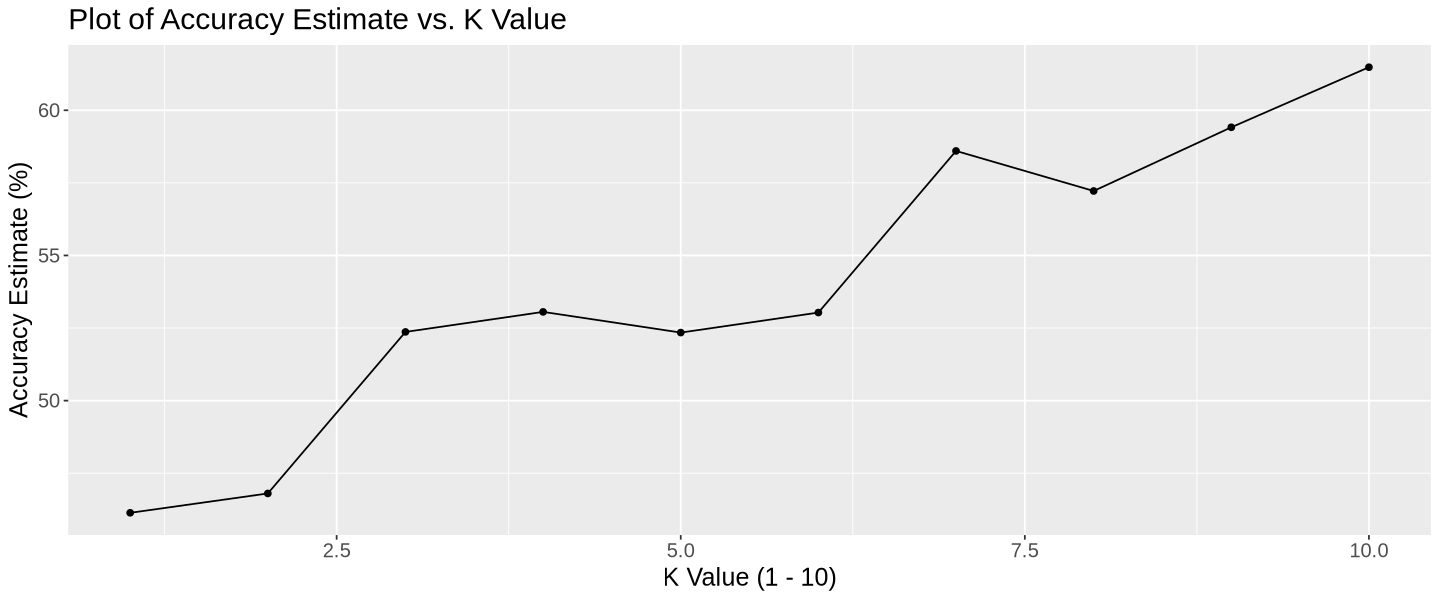

In [580]:
options(repr.plot.height = 5, repr.plot.width = 12)

K_plot <- K_metrics |>
    mutate(mean = mean * 100) |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "K Value (1 - 10)", y = "Accuracy Estimate (%)") +
        ggtitle("Plot of Accuracy Estimate vs. K Value") +
        theme(text = element_text(size = 15))
K_plot

- Recreating model specification with new value of K
- Creating new workflow with new model specification

In [581]:
set.seed(4)

# creating model specification with K = 10
player_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_K) |>
    set_engine("kknn") |>
    set_mode("classification")

# recreating workflow with new model specification
player_fit2 <- workflow() |>
    add_model(player_spec2) |>
    add_recipe(player_recipe) |>
    fit(data = player_train)

- Predicting on test data
- Evaluating performance of model on test data using `metrics`

In [582]:
set.seed(4)

# predicting on test data
player_predict <- player_fit2 |>
    predict(player_test) |>
    bind_cols(player_test)

# determining model accuracy on test data in percent
player_accuracy <- player_predict |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    mutate(.estimate = .estimate * 100) |>
    pull(.estimate)

player_accuracy

[1] 71.42857

***TABLE 4: Model Confusion Matrix***

In [583]:
player_confusion_matrix <- player_predict |>
    conf_mat(truth = subscribe, estimate = .pred_class)

player_confusion_matrix

          Truth
Prediction FALSE TRUE
     FALSE     7    8
     TRUE      6   28

- Showing precision in percent (%), switching positive and negative labels with `event_level` argument

In [584]:
player_precision <- player_predict |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second") |>
    mutate(.estimate = .estimate * 100) |>
    pull(.estimate)

player_precision

[1] 82.35294

- Showing recall in percent (%), switching positive and negative labels with `event_level` argument

In [585]:
player_recall <- player_predict |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second") |>
    mutate(.estimate = .estimate * 100) |>
    pull(.estimate)

player_recall

[1] 77.77778

---

**Visualising data analysis of K-NN classification.**

Discussion:
---
* summarize what you found
* discuss whether this is what you expected to find?
* discuss what impact could such findings have?
* discuss what future questions could this lead to?

**Summary**

---
It was discovered through exploring the data that no players who had 0 hours of playtime under the played_hours column were subscribed to the newsletter. This was used to simplify the data by filtering out all of the players with 0 hours of playtime, to remove the data being heavily centered around `FALSE` subscriber status

The model, performing on the training data, showed maximal accuracy with a K neighbours value of 7. With this value of K, the model predicted on the testing data, giving the evaluation metrics:
- accuracy ~ 71.4%
- precision ~ 82.4%
- recall = 77.8%

**Expectations**

---
The metrics are inconsistent with the expectations that `played_hours` and `Age` can reasonably be used to predict the subscription status of players. A recall of 77.8% indicates that of all positive, meaning `TRUE` observations that exist in the data, the model predicted about three-quarters of them correctly. Further, the roughly 82.4% precision represents that the model predicted positive labels correctly for all of its positive predictions. Here, a deficiency of the model would be the recall. The 77.8% recall and 82.4% precision may suggest that the model tends to predict the negative label more often than the positive label, as it incorrectly chose `FALSE` many more times than it correctly did. While the metric values are reasonably high, they, alongside the confusion matrix, indicate that the model incorrectly predicts `FALSE` far too often for the model to be useful at predicting unseen data.

**Potential Impacts**

---
These findings, with their reasonable metrics, could have potential impacts if there is truly a relationship between the predictors, `played_hours` and `Age`, and the response variable, `subscribe`. These findings could be used to target certain demographics of players with advertisements about game-related newsletters for games that they enjoy, which includes more advertisements for other games. Game developers could use these findings to push their games to the right audiences. These findings could also be used among players themselves, to see if players of similar characteristics are also subscribed, involving them in the community of that game. However, under the knowledge that the model predicted the negative label far more often than it actually appeared in the data, this could potentially be indicative that there is no relationship, putting advertisers and developers at a loss for who to market to.

**Future Questions**

---
- Could skill level be a meaningful predictor for predicting subscription status in `players.csv`?
- Why is the model simply predicting `FALSE` much more often than `TRUE`?
- Because the model chose a value of K that was a bound of the grid values, would increasing the grid size mean the value of K would necessarily get larger? Is it worth it to slow down the model runtime significantly to test this and run the risk of underfitting the data with too high a value of K?

References:
---
* You may include references if necessary, as long as they all have a consistent citation style.